### Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
from tensorflow. keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn. model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns


### Defining the path of dataset directory

In [3]:
dataset_path = "C:\\Users\\mouad\\plant-disease-detection\\data\\dataset - Copie"


### Visualizing the images and Resize images

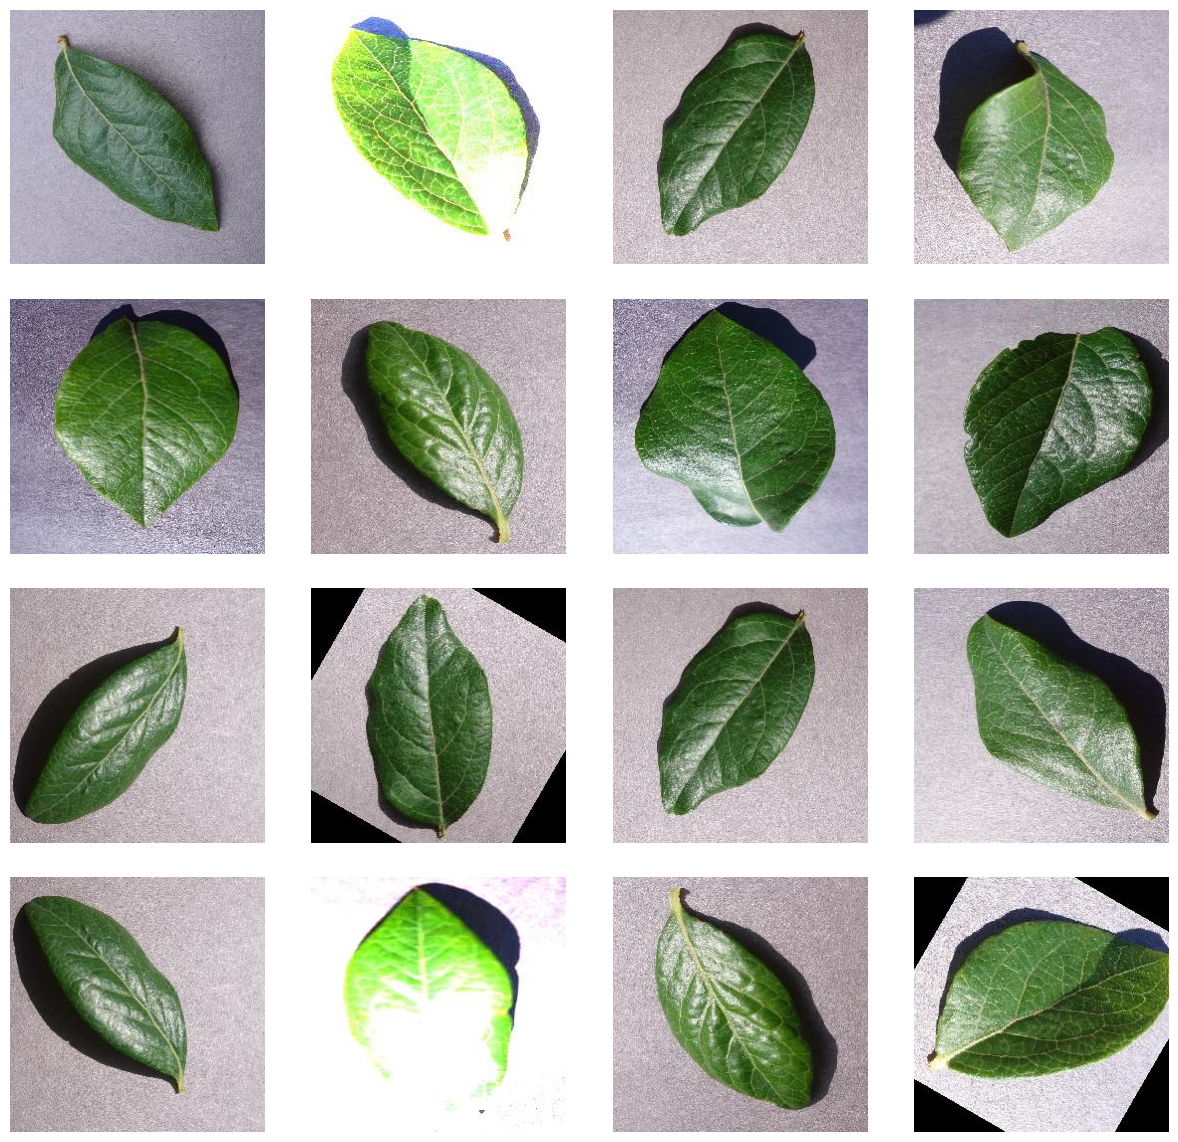

In [4]:
plt.figure(figsize=(12, 12))

class_name = "Blueberry___healthy"
img_folder = os.path.join(dataset_path, "train", class_name)

for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.tight_layout()

    rand_img = imread(os.path.join(img_folder, random.choice(os.listdir(img_folder))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize=10)  # width
    plt.ylabel(rand_img.shape[0], fontsize=10)  # height
    plt.axis('off')

plt.show()


### Convert the images into a Numpy array and normalize them

In [5]:
# Converting Images to array 

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256, 256))  
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
# Data Preprocessing Parameters
IMG_SIZE = 224
BATCH_SIZE = 32

train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 3100 images belonging to 38 classes.
Found 3036 images belonging to 38 classes.


In [7]:
# Initialize lists for image paths and labels
image_paths = []
labels = []

# Loop through both train and valid directories
for split in ['train', 'valid']:
    split_folder = os.path.join(dataset_path, split)
    
    # Loop through each folder (class) in the dataset
    for class_name in os.listdir(split_folder):
        class_folder = os.path.join(split_folder, class_name)
        
        # If it is a directory (class folder)
        if os.path.isdir(class_folder):
            for image_filename in os.listdir(class_folder):
                # Full path to image
                image_path = os.path.join(class_folder, image_filename)
                
                # Append image path and class label
                image_paths.append(image_path)
                labels.append(class_name)

# Create a DataFrame with image paths and corresponding labels
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Display the first few rows of the dataframe
print(df.head())


                                          image_path               label
0  C:\Users\mouad\plant-disease-detection\data\da...  Apple___Apple_scab
1  C:\Users\mouad\plant-disease-detection\data\da...  Apple___Apple_scab
2  C:\Users\mouad\plant-disease-detection\data\da...  Apple___Apple_scab
3  C:\Users\mouad\plant-disease-detection\data\da...  Apple___Apple_scab
4  C:\Users\mouad\plant-disease-detection\data\da...  Apple___Apple_scab


In [8]:
# Check the unique classes in the label column
num_classes = df['label'].nunique()
print(f"Total number of classes: {num_classes}")

# Get the total number of images in the DataFrame
total_images = df.shape[0]
print(f"Total number of images: {total_images}")



Total number of classes: 38
Total number of images: 6136


In [ ]:
# Data Preprocessing Parameters
IMG_SIZE = 224
BATCH_SIZE = 256

train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 3100 images belonging to 38 classes.
Found 3036 images belonging to 38 classes.


### Visualize the class count and Check for class imbalance

C:\Users\mouad\AppData\Local\Temp\ipykernel_13460\2301443978.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


Text(0.5, 1.0, 'Distribution of Images per Class')

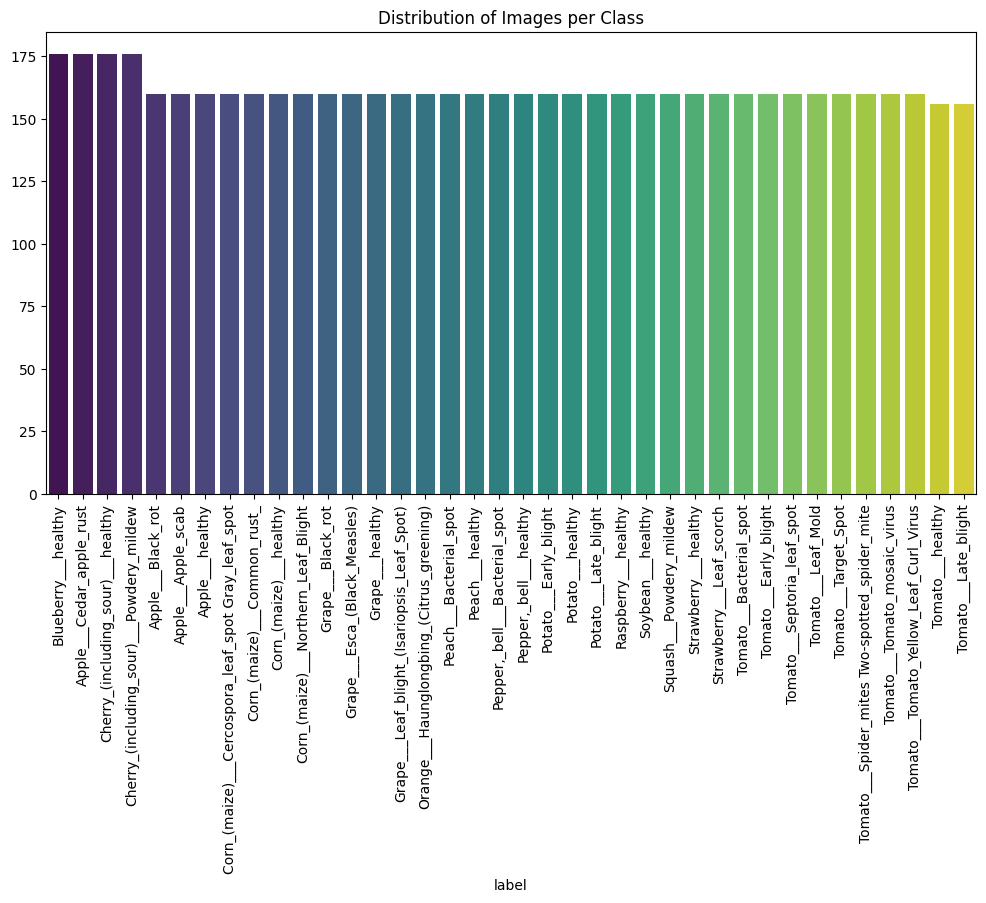

In [10]:
# Count the number of images per class (for both train and valid)
class_counts = df['label'].value_counts()

# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Distribution of Images per Class")


In [11]:
# Load an image (change the path to one of your image file paths)
image_path = df['image_path'][1]  # Take the first image from the DataFrame
image = cv2.imread(image_path)


# Print the shape of the image
print(f"Image shape: {image.shape}")  # (height, width, channels)



Image shape: (256, 256, 3)


### Splitting the dataset into train, validate and test sets

In [12]:
# Extract the features (image paths) and labels from the dataframe
X = df['image_path'].values
y = df['label'].values

# First, split into train and temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Then split the temp into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Check the number of samples in each set
print(f"X_train: {len(X_train)}")
print(f"X_valid: {len(X_valid)}")
print(f"X_test: {len(X_test)}")


X_train: 4908
X_valid: 614
X_test: 614


### Performing one-hot encoding on target variable

In [13]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding (converts labels to integers)
label_encoder = LabelEncoder()

# Fit on training labels and transform all datasets
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

# One-Hot Encoding (converts integer labels to one-hot vectors)
y_train_one_hot = to_categorical(y_train_encoded)
y_valid_one_hot = to_categorical(y_valid_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

### Creating the model architecture, compile the model and then fit it using the training data

In [14]:
# Initialize the CNN model
model = Sequential()

# Step 1: Convolutional Layer + Max Pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Step 2: Convolutional Layer + Max Pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Step 3: Flatten the output from the convolutional layers
model.add(Flatten())

# Step 4: Fully Connected Layer
model.add(Dense(128, activation='relu'))

# Step 5: Dropout to prevent overfitting
model.add(Dropout(0.5))

# Step 6: Output Layer (softmax for multi-class classification)
model.add(Dense(38, activation='softmax'))


C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs to wait before stopping
    verbose=1,           # Display messages when stopping early
    restore_best_weights=True  # Restore the best weights
)


In [1]:
# Train the model
history = model.fit(
    train_generator,  # The training dataset
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,        # Maximum number of epochs
    validation_data=valid_generator,  # The validation dataset
    validation_steps=valid_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping]  # Early stopping callback
)


NameError: name 'model' is not defined

In [ ]:
model.save("C:/Users/mouad/plant-disease-detection/model/plant_disease_model.h5")

### Plot the accuracy and loss against each epoch

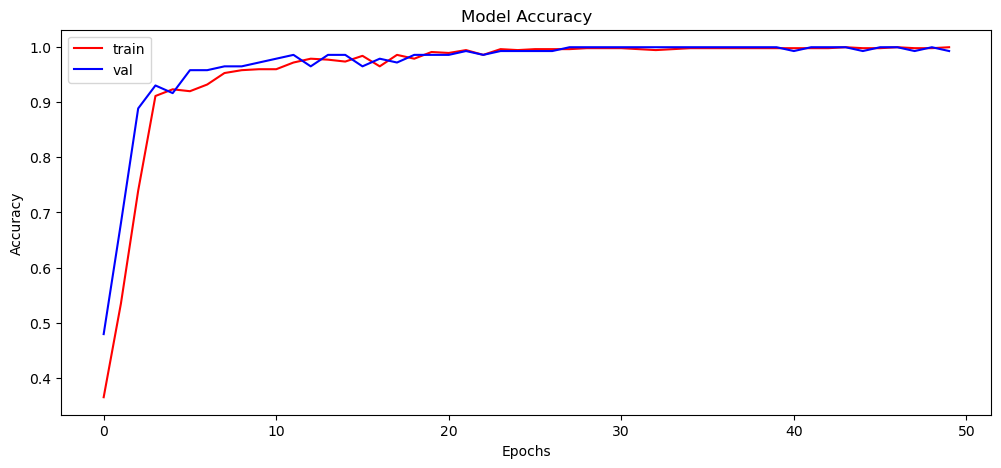

In [ ]:
# Plot the training history

plt.figure(figsize = (12, 5))
plt.plot(history.history['accuracy'], color = 'r')
plt.plot(history.history['val_accuracy'], color = 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [ ]:
print("Calculating model accuracy")

scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1] * 100}")

Calculating model accuracy
6/6 [==============================] - 1s 116ms/step - loss: 0.0246 - accuracy: 0.9944
Test Accuracy: 99.44444298744202


### Make predictions on testing data

In [ ]:
y_pred = model.predict(X_test)

6/6 [==============================] - 1s 106ms/step


### Visualizing the original and predicted labels for the test images

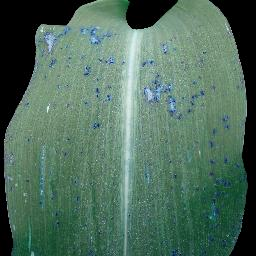

In [ ]:
# Plotting image to compare

img = array_to_img(X_test[11])
img

In [ ]:
# Finding max value from predition list and comaparing original value vs predicted

print("Originally : ", all_labels[np.argmax(Y_test[11])])
print("Predicted : ", all_labels[np.argmax(Y_pred[4])])
print(y_pred[2])

Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
[7.9205156e-06 2.2908032e-02 9.7708410e-01]


In [ ]:
for i in range(50):
    print (all_labels[np.argmax(y_test[i])], " ", all_labels[np.argmax(y_pred [1])])

Potato-Early_blight   Corn-Common_rust
Corn-Common_rust   Corn-Common_rust
Tomato-Bacterial_spot   Corn-Common_rust
Corn-Common_rust   Corn-Common_rust
Corn-Common_rust   Corn-Common_rust
Tomato-Bacterial_spot   Corn-Common_rust
Corn-Common_rust   Corn-Common_rust
Potato-Early_blight   Corn-Common_rust
Potato-Early_blight   Corn-Common_rust
Potato-Early_blight   Corn-Common_rust
Potato-Early_blight   Corn-Common_rust
Corn-Common_rust   Corn-Common_rust
Tomato-Bacterial_spot   Corn-Common_rust
Tomato-Bacterial_spot   Corn-Common_rust
Corn-Common_rust   Corn-Common_rust
Tomato-Bacterial_spot   Corn-Common_rust
Corn-Common_rust   Corn-Common_rust
Corn-Common_rust   Corn-Common_rust
Tomato-Bacterial_spot   Corn-Common_rust
Tomato-Bacterial_spot   Corn-Common_rust
Tomato-Bacterial_spot   Corn-Common_rust
Corn-Common_rust   Corn-Common_rust
Corn-Common_rust   Corn-Common_rust
Tomato-Bacterial_spot   Corn-Common_rust
Potato-Early_blight   Corn-Common_rust
Tomato-Bacterial_spot   Corn-Common_r